**Zipper: classification with gradient boosting (and autotuning)**
---
Companion notebooks from the medium article [Deep Zip: an open zipper detector](https://medium.com/@jfrederic.plante/deep-zip-83eb78f9963e).

There are 3 parts:
- [part1](https://www.kaggle.com/blocks/zipper-putting-it-all-together-part-1): data exploration and preprocessing
- [part2](https://www.kaggle.com/blocks/zipper-putting-it-all-together-part-2): classification with gradient boosting (and autotuning)
- [part3](https://www.kaggle.com/blocks/zipper-putting-it-all-together-part-3): convnet and lstm

You can also find the capture app for iOS at https://github.com/jeanfredericplante/lowflyer

---

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import fastai
import math
import datetime
import matplotlib.pyplot as plt
import os
import lightgbm as lgb
from tqdm import tqdm, tqdm_notebook
import plotly.graph_objs as go

In [2]:
df_all = pd.read_pickle('../input/df_all_norm.pkl') 
# df_all = pd.read_pickle('../input/df_all.pkl')
size_per_batch = pd.read_pickle('../input/size_per_batch.pkl')

In [3]:
df_all.batch.unique().size

59

In [4]:
size_per_batch.head(3)

,length,open,walking
batch,,,
0,960,1,1
1,2802,1,1
2,1543,1,1


Train  / Test selection



In [5]:
def select_train_test_batches(size_per_batch, label = "walking",percent = 0.2):
    target = label # "open" or "walking"
    percent_test = percent
    size_per_batch= size_per_batch.reset_index().set_index([target,'batch']).sort_index()
    target_per_class = size_per_batch.groupby(target).sum()*percent_test
    test_batches = []
    target_length = 0
    while target_length < target_per_class.iloc[0].length:
        sample_batch = size_per_batch.xs(0).sample()
        target_length += sample_batch.length.values[0]
        test_batches.append(sample_batch.index.values[0])
    target_length = 0
    while target_length < target_per_class.iloc[1].length:
        sample_batch = size_per_batch.xs(1).sample()
        target_length += sample_batch.length.values[0]
        test_batches.append(sample_batch.index.values[0])
    train_batches = size_per_batch.index.levels[1].values
    train_batches = set(train_batches) - set(test_batches)
    print(f"train batch:{train_batches}, test batches {test_batches}")
    return train_batches,test_batches

def balance_training_set(X_trn, Y_trn):
    Y_trn = np.array(Y_trn)
    walking_count = np.count_nonzero(Y_trn)
    still_count = np.count_nonzero(1-Y_trn)
    print(f'walking {walking_count}, still {still_count}, ratio {walking_count/still_count:.2f}')
    Y_trn_still_idx = np.where(Y_trn == 0)[0]
    idx_rebalance = np.random.choice(Y_trn_still_idx, abs(walking_count-still_count))
    Y_trn = np.append(Y_trn,Y_trn[idx_rebalance])
    X_trn = np.vstack((X_trn,X_trn[idx_rebalance]))
    return X_trn, Y_trn

# A bit of feature engineering
def create_training_with_fft(window_size = 128, step_size = 10, batch_list=[],
                             features=["aa","ax","ay","az"], fft_only=False, remove_0_freq=True, get_batchlist = False,
                             return_neg_freq = False, flatten = True):
    x = [] ; y = [] ; blist = []
    if not batch_list: batch_list = df_all.batch.unique()
    for batch in batch_list:
        dftmp = df_all[df_all.batch==batch]
        for i in range(0, dftmp.ma.size-window_size,step_size):
            dfsub = dftmp.iloc[i:i+window_size]
            feat_val=dfsub[features].values
            if remove_0_freq:
                feat_val_fft = (dfsub - dfsub.mean())[features].values
            else:
                feat_val_fft = feat_val
            n = len(feat_val_fft)
            fft_feat_val = abs(np.fft.fft(feat_val_fft.T)/n).T    
            if not return_neg_freq:
                fft_feat_val = fft_feat_val[np.arange(n/2,dtype=int)] 
            if fft_only:
                if flatten: x.append(fft_feat_val.T.flatten())
                else: x.append(fft_feat_val.T)
            else:
                if flatten:x.append(np.hstack((feat_val.T.flatten(), fft_feat_val.T.flatten())))
                else: x.append(np.vstack((feat_val.T, fft_feat_val.T)))
            y.append(dfsub[target].values[0])
            blist.append(batch)
    if get_batchlist: return np.array(x),np.array(y),blist
    else: return np.array(x),np.array(y)

Utility functions

In [6]:
from sklearn.metrics import roc_curve, recall_score, precision_score
def get_precision_recall(X,y,m):
    return  precision_score(y,m.predict(X)),recall_score(y,m.predict(X))

import seaborn as sns
from sklearn.metrics import confusion_matrix,precision_score, recall_score
# recall for zipper open is maximize rate of detection the flyer is open (minimize false negatives).
# recall: real->detected max, precision: detected -> real max (minimize false positives)

def plot_confusion_matrix(Y_true, Y_pred, label="walking",ax=[]):
    cm = confusion_matrix( Y_true, Y_pred)
    prec= precision_score(Y_true, Y_pred)
    rec = recall_score(Y_true,Y_pred)
    if label is "walking":
        labels = ["still","walking"]
    else:
        labels = ["close","open"]
    cm_df = pd.DataFrame(cm,index = labels, columns = labels)
    sns.heatmap(cm_df, annot=True,ax=ax)
    ax.set_title(f'Confusion Matrix, prec {prec:.2f} - recall {rec:.2f}')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# Gradient boosting with LGBM

## Walking vs. Still classifier

In [7]:
# targeting walking and non walking
target = "walking"
train_batches,test_batches = select_train_test_batches(size_per_batch,label = target, percent = 0.2)
# lgb_params ={'boosting_type': 'gbdt', 'lambda_l1': 0.07013102270356747, 'lambda_l2': 0.8442787399572204, 'max_bin': 82, 'min_data_in_leaf': 310, 'num_leaves': 33, 'subsample': 0.8377796877710598, 'n_estimators': 556}

train batch:{2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60}, test batches [16, 15, 43, 0, 13, 1, 9, 55, 54, 45]


>>train: precision 1.00, recall 1.00  >>val: precision 1.00, recall 0.99


Text(0.5, 1.0, 'Validation: Confusion Matrix, prec 1.00 - recall 0.99')

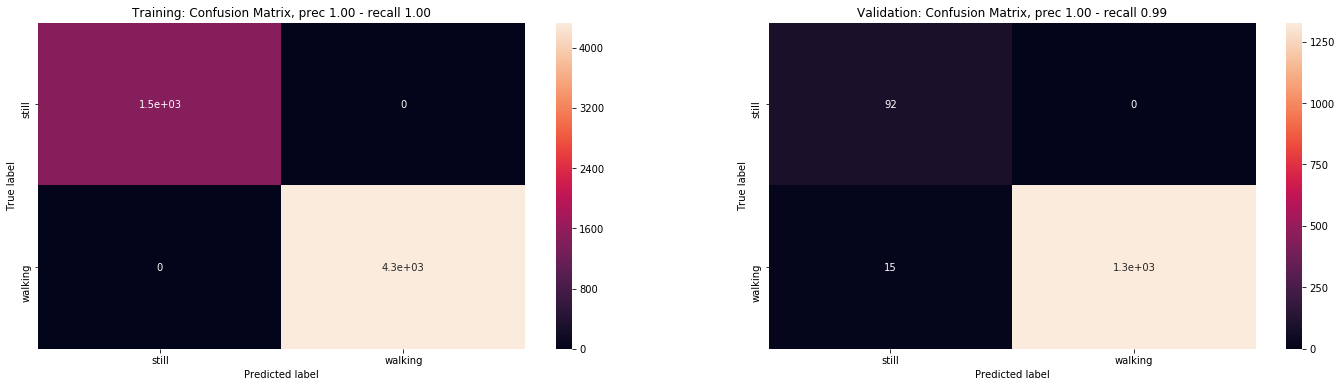

In [8]:
features = ["ax","ay","az"];
ws = 128; fft_only = False;  remove_0freq = True
X_trn,Y_trn, blist_trn = create_training_with_fft(batch_list=train_batches,features=features, window_size=ws, fft_only=fft_only, remove_0_freq=remove_0freq, get_batchlist=True, return_neg_freq = True)
X_val,Y_val, blist_val = create_training_with_fft(batch_list=test_batches,features=features, window_size=ws, fft_only=fft_only, remove_0_freq=remove_0freq, get_batchlist=True, return_neg_freq = True)
m = lgb.LGBMClassifier()
m.fit(X_trn,Y_trn)
o =">>train: precision %.2f, recall %.2f" % get_precision_recall(X_trn, Y_trn, m)
o += "  >>val: precision %.2f, recall %.2f" % get_precision_recall(X_val, Y_val, m)
print(o)

fig,axes = plt.subplots(1,2,figsize=(24,6))
plot_confusion_matrix(Y_trn,m.predict(X_trn),label="walking",ax=axes[0]);axes[0].set_title("Training: " + axes[0].get_title())
plot_confusion_matrix(Y_val,m.predict(X_val),label="walking",ax=axes[1]);axes[1].set_title("Validation: " + axes[1].get_title())

#### Looking at samples in the 4 quadrants of validation

In [9]:
def print_quadrants_examples(X, Y, blist, m):
    # Analysis of the bad ones

    preds = m.predict(X)
    blist = np.array(blist); #Y_val = np.array(Y_val); 
    idx_fails = preds != Y
    idx_ok = preds == Y

    idx_fn = np.where(idx_fails & (Y == 1) == True)[0]
    idx_fp = np.where(idx_fails & (Y == 0) == True)[0]
    b_fn = blist[idx_fn]; b_fp = blist[idx_fp]
    b_fn, b_fn_count = np.unique(b_fn, return_counts=True)
    b_fp, b_fp_count = np.unique(b_fp, return_counts=True)
    idx_tn = np.where(idx_ok & (Y == 0) == True)[0]
    idx_tp = np.where(idx_ok & (Y == 1) == True)[0]
    print(f'false neg {b_fn}, counts {b_fn_count}. false pos {b_fp}, count {b_fp_count}')
    quadrants_dict = {'fn': 'false negatives', 'fp': 'false positives', 'tp': 'true positives', 'tn': 'true negatives'}
    def print_quadrant(quadrant='fp', idx=idx_fp):
        if len(idx) >= 6:
            fig,ax = plt.subplots(2,3,figsize=(15,5))
            for _, axi in enumerate(fig.axes):
                i=np.random.choice(idx)
                axi.plot(X[i].reshape(6,-1)[0]); axi.set_title(quadrants_dict[quadrant])
    print_quadrant(quadrant='tp', idx=idx_tp)
    print_quadrant(quadrant='tn', idx=idx_tn)
    print_quadrant(quadrant='fp', idx=idx_fp)
    print_quadrant(quadrant='fn', idx=idx_fn)

false neg [55], counts [15]. false pos [], count []


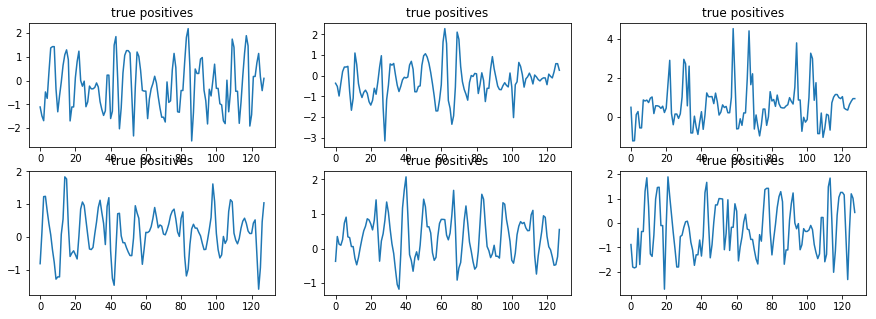

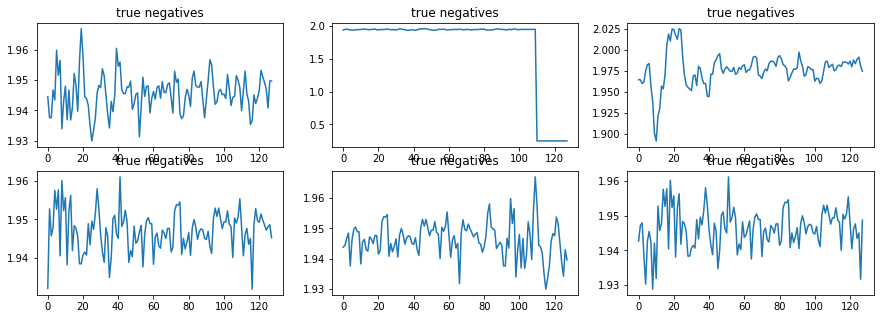

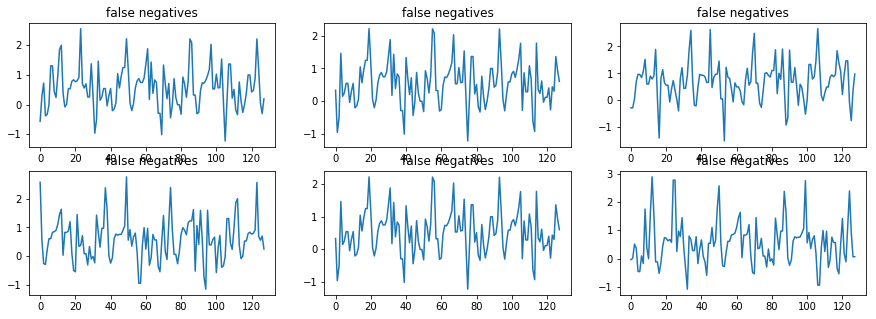

In [10]:
print_quadrants_examples(X_val, Y_val, blist_val, m)

## Open vs Close

In [11]:
target = "open"
train_batches,test_batches = select_train_test_batches(size_per_batch[size_per_batch.walking==1],label = target, percent = 0.2)

train batch:{0, 1, 2, 5, 6, 9, 10, 11, 13, 17, 18, 20, 21, 22, 23, 29, 30, 33, 34, 39, 40, 41, 43, 44, 45, 47, 49, 50, 51, 53, 55, 56}, test batches [38, 12, 35, 46, 19, 54, 46, 36, 27]


In [12]:
# # in order to reproduce the same batch as when optimized
# train_batches = {0, 1, 2, 5, 6, 9, 11, 12, 13, 17, 18, 19, 20, 21, 23, 27, 30, 33, 35, 39, 41, 43, 44, 45, 46, 47, 49, 50, 51, 53, 54, 55, 56}
# test_batches = [38, 34, 36, 22, 29, 40, 10]
train_batches = {1, 5, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 29, 30, 33, 35, 36, 38, 40, 41, 43, 44, 45, 46, 49, 50, 51, 54, 55, 56}
test_batches = [34, 39, 34, 39, 6, 17, 47, 0, 53, 2, 27]

>>train: precision 1.00, recall 1.00  >>val: precision 0.67, recall 0.66


Text(0.5, 1.0, 'Validation: Confusion Matrix, prec 0.67 - recall 0.66')

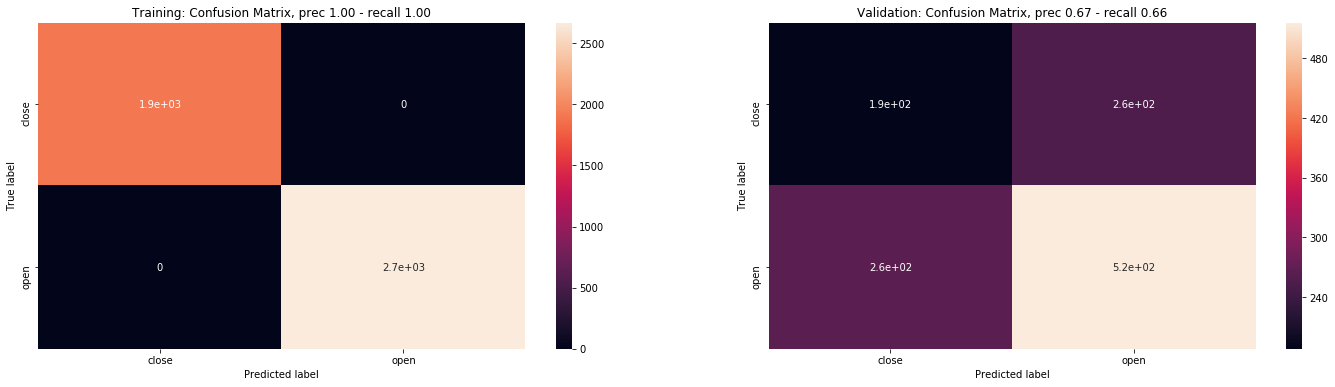

In [13]:
features = ["mx","my","mz","ax","ay","az"];

# features = ['ma',"mx","my","mz"]
ws = 128; fft_only = False;  remove_0freq = True
# m = lgb.LGBMClassifier(random_state=1,max_bins=4)
X_trn,Y_trn, blist_trn = create_training_with_fft(batch_list=train_batches,features=features, window_size=ws, fft_only=fft_only, remove_0_freq=remove_0freq, get_batchlist=True, return_neg_freq = True)
X_val,Y_val, blist_val = create_training_with_fft(batch_list=test_batches,features=features, window_size=ws, fft_only=fft_only, remove_0_freq=remove_0freq, get_batchlist=True, return_neg_freq = True)
m = lgb.LGBMClassifier(random_state=1)
m.fit(X_trn,Y_trn)
o =">>train: precision %.2f, recall %.2f" % get_precision_recall(X_trn, Y_trn, m)
o += "  >>val: precision %.2f, recall %.2f" % get_precision_recall(X_val, Y_val, m)
print(o)

fig,axes = plt.subplots(1,2,figsize=(24,6))
plot_confusion_matrix(Y_trn,m.predict(X_trn),label="open",ax=axes[0]);axes[0].set_title("Training: " + axes[0].get_title())
plot_confusion_matrix(Y_val,m.predict(X_val),label="open",ax=axes[1]);axes[1].set_title("Validation: " + axes[1].get_title())

In [14]:
np.save('preds',m.predict(X_val))
np.save('preds_probs',m.predict_proba(X_val))
np.save('y_val',Y_val )

false neg [ 2 17 47 53], counts [111  22   5 127]. false pos [ 6 39], count [105 150]


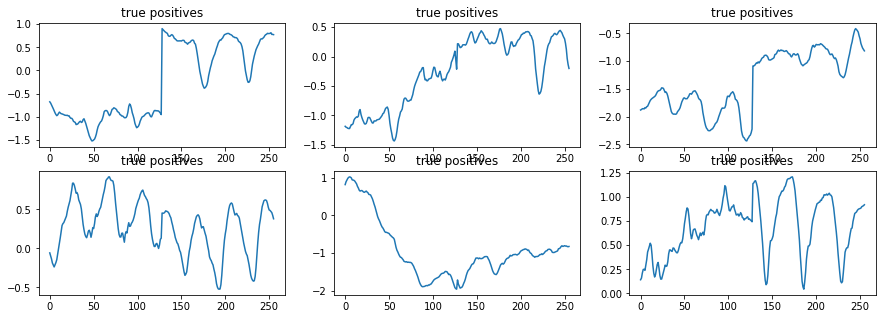

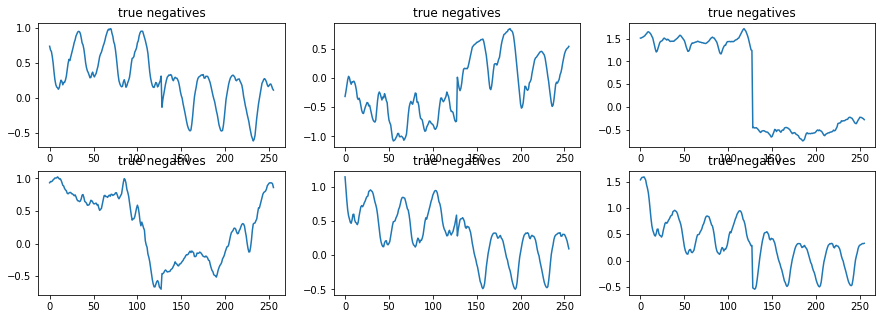

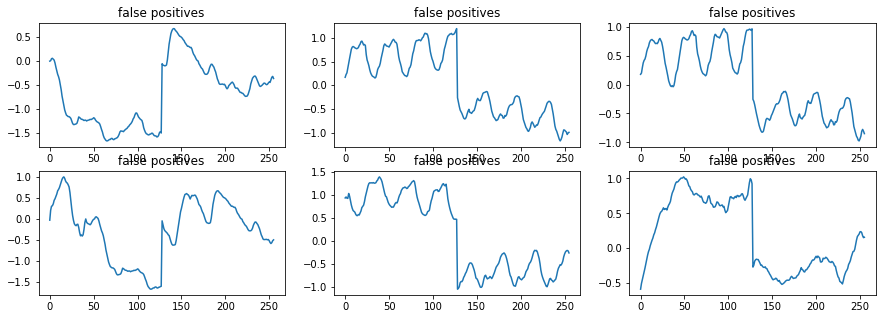

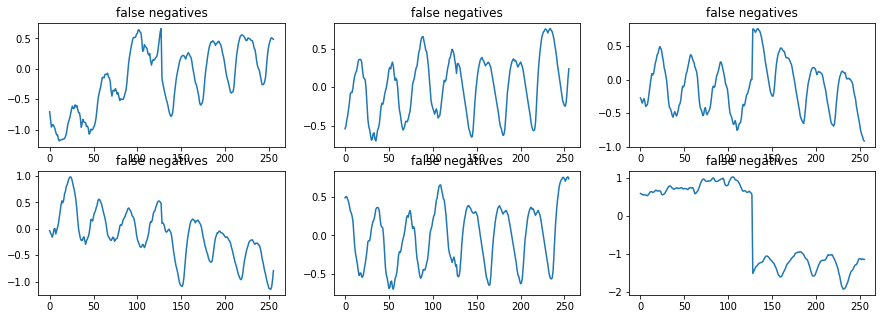

In [15]:
print_quadrants_examples(X_val, Y_val, blist_val, m)

## Parameter optimization

Defining the objective function
Heavily inspired from Will Koehrsen's great article on Kaggle
https://www.kaggle.com/willkoehrsen/automated-model-tuning

In [16]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    if ITERATION == 0:
        # Adds headers to the csv file
        of_connection = open(OUT_FILE, 'w')
        writer = csv.writer(of_connection)
        # Write column names
        headers = ['loss', 'hyperparameters', 'iteration']
        writer.writerow(headers)
        of_connection.close()
    ITERATION += 1
    
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Num boosting round <=> n estimators
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'min_data_in_leaf', 'max_bin']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set,  nfold = 5, metrics = 'binary_logloss', seed = 1,
                       num_boost_round = 10000, early_stopping_rounds = 10)

    # Extract the best score
    best_score = cv_results['binary_logloss-mean'][-1]
    loss = best_score
    n_estimators = len(cv_results['binary_logloss-mean'])
   
    hyperparameters['n_estimators'] = n_estimators
    
    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'status': STATUS_OK}

In [17]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 2, 150, 1),
    'max_bin': hp.quniform('max_bin', 3, 100, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 500, 5),
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
    'lambda_l2': hp.uniform('lambda_l2', 0.0, 1.0),
}


In [18]:
from hyperopt import Trials, tpe, fmin

# Record results
global  ITERATION; ITERATION = 0
trials = Trials()
OUT_FILE = 'zipper_lgb_optim.csv'

# Run optimization
m = lgb.LGBMClassifier(random_state=1)
train_set = lgb.Dataset(X_trn, label = Y_trn)
test_set = lgb.Dataset(X_val, label = Y_val)

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = 1)

100%|██████████| 1/1 [02:19<00:00, 139.98s/it, best loss: 0.05775040533076631]


In [19]:
trials_dict = sorted(trials.results, key = lambda x: x['loss'])
opt_params = trials_dict[0]['hyperparameters']
print(opt_params)

{'boosting_type': 'gbdt', 'lambda_l1': 0.07297412412024018, 'lambda_l2': 0.9684755369080202, 'max_bin': 81, 'min_data_in_leaf': 270, 'num_leaves': 94, 'subsample': 0.5526631940665425, 'n_estimators': 704}


>>train: precision 1.00, recall 1.00  >>val: precision 0.68, recall 0.65


Text(0.5, 1.0, 'Validation: Confusion Matrix, prec 0.68 - recall 0.65')

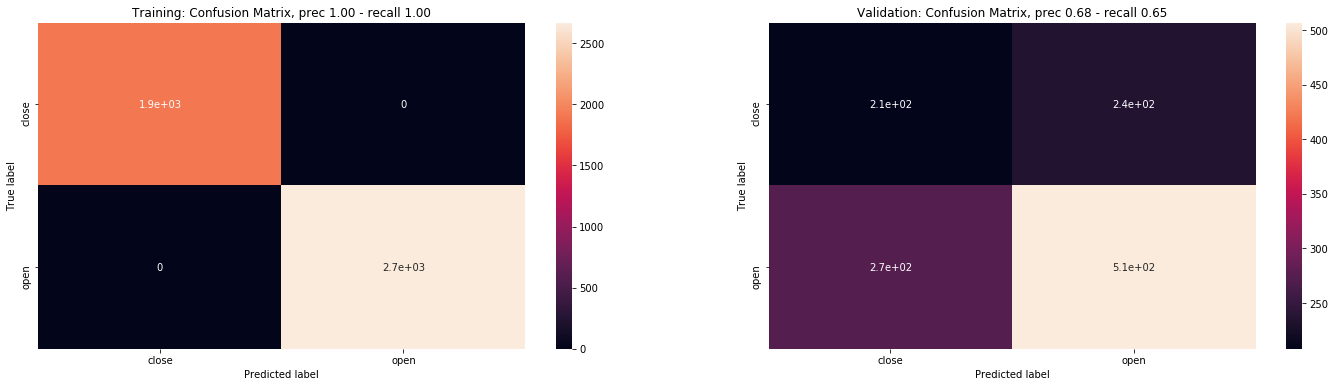

In [20]:
features = ["mx","my","mz"];
features = ["mx","my","mz","ax","ay","az"];

ws = 128; fft_only = False;  remove_0freq = True
m = lgb.LGBMClassifier(**opt_params, random_state=1)
X_trn,Y_trn, blist_trn = create_training_with_fft(batch_list=train_batches,features=features, window_size=ws, fft_only=fft_only, remove_0_freq=remove_0freq, get_batchlist=True, return_neg_freq = True)
X_val,Y_val, blist_val = create_training_with_fft(batch_list=test_batches,features=features, window_size=ws, fft_only=fft_only, remove_0_freq=remove_0freq, get_batchlist=True, return_neg_freq = True)
m.fit(X_trn,Y_trn)
o =">>train: precision %.2f, recall %.2f" % get_precision_recall(X_trn, Y_trn, m)
o += "  >>val: precision %.2f, recall %.2f" % get_precision_recall(X_val, Y_val, m)
print(o)

fig,axes = plt.subplots(1,2,figsize=(24,6))
plot_confusion_matrix(Y_trn,m.predict(X_trn),label="open",ax=axes[0]);axes[0].set_title("Training: " + axes[0].get_title())
plot_confusion_matrix(Y_val,m.predict(X_val),label="open",ax=axes[1]);axes[1].set_title("Validation: " + axes[1].get_title())